In [1]:
import pandas as pd 
import os
os.chdir("/home/robbe/ionbot")
import OxiAnalysis as OA
os.chdir("/home/robbe/ionbot/Ageing_study/")
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [2]:
quant = pd.read_csv("Ageing_combined.csv", index_col=[0])

In [3]:
SI = OA.summedintensities(quant)

In [4]:
SI

,Modifications,Gene Names,Organism,Intensity_150828_PC_VUR_C1077,Intensity_150828_PC_VUR_C1133,Intensity_150828_PC_VUR_C1134,Intensity_150828_PC_VUR_C1138,Intensity_150828_PC_VUR_C1189,Intensity_150828_PC_VUR_C1205,Intensity_150828_PC_VUR_C1256,...,Intensity_1DLC012615QE_RRAG_014B_rep1,Intensity_1DLC012615QE_RRAG_014B_rep2,Intensity_1DLC051815QE_RRAG_011B_rep1,Intensity_1DLC051815QE_RRAG_011B_rep2,Intensity_1DLC051815QE_RRAG_028B_rep1,Intensity_1DLC051815QE_RRAG_028B_rep2,Intensity_1DLC052815QE_RRAG_024B_rep1,Intensity_1DLC052815QE_RRAG_024B_rep2,Intensity_1DLC052815QE_RRAG_025B_rep1,Oxmod?
0,[1384]Homocysteic_acid[M],0.0,0.0,0.000000,0.000000,0.000000,0.000071,0.000000,0.000058,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,35
1,[1914]Met->AspSA[M],0.0,0.0,0.000000,0.000000,0.000139,0.000075,0.000076,0.000070,0.000142,...,0.000000,0.000000,0.0,0.000089,0.000000,0.000093,0.000000,0.0001,0.000101,66
2,[1915]Decarboxylation[D],0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000040,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000085,0.000000,0.000000,0.0000,0.000086,27
3,[1915]Decarboxylation[E],0.0,0.0,0.000090,0.000000,0.000000,0.000000,0.000134,0.000039,0.000080,...,0.000000,0.000000,0.0,0.000000,0.000122,0.000000,0.000000,0.0000,0.000000,52
4,[1916]Aspartylurea[H],0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000068,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,[743]4-ONE+Delta:H(-2)O(-1)[H],0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,2
83,[860]G-H1[R],0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,7
84,[936]Chlorination[Y],0.0,0.0,0.000096,0.000075,0.000000,0.000132,0.000096,0.000091,0.000117,...,0.000141,0.000124,0.0,0.000150,0.000000,0.000000,0.000000,0.0000,0.000000,54
85,[937]dichlorination[Y],0.0,0.0,0.000000,0.000095,0.000000,0.000068,0.000049,0.000056,0.000084,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,14


In [5]:
Young = SI.filter(regex="Modifications|Protein Groups|PC_VUR")
Old = SI.filter(regex="Modifications|Protein Groups|RRAG")

In [6]:
#To drop rows where more than half of the columns give 0 values
Youngthreshold = (Young.shape[1] - 3) / 2
Oldthreshold = (Old.shape[1] - 3) /2

In [7]:
Oldfiltered = Old.loc[(Old == 0).sum(axis=1) < Oldthreshold]
Youngfiltered = Young.loc[(Young == 0).sum(axis=1) < Youngthreshold] 

# Boxplot

In [8]:
def boxplots(Controldf, Treatmentdf, specific=True):
    import scipy.stats as stats
    from statsmodels.stats.multitest import multipletests
    from pyteomics import mass as pymass
    from itertools import combinations
    import re
    from statannotations.Annotator import Annotator
    db = pymass.Unimod()

    pvallist = []
    for index, row in Controldf.iterrows():
        for index2, row2 in Treatmentdf.iterrows():
            if index == index2:
                if specific:
                    mod = row["Modifications"]
                    modname = re.search(pattern=r"\[\d+\](.*)", string=mod).group(1)
                # else:
                #     modname = "Dioxidation"
                dataControl = Controldf.iloc[index][1:]
                dataControl = dataControl.astype(float)
                dataControl = dataControl.astype(float)
                dataControl = dataControl[dataControl != 0]
                dataTreatment = Treatmentdf.iloc[index][1:]
                dataTreatment = dataTreatment.astype(float)
                dataTreatment = dataTreatment[dataTreatment !=0]
                if dataTreatment.size != 0 and dataControl.size != 0:
                    pval = stats.mannwhitneyu(dataControl, dataTreatment).pvalue
                    pvallist.append(pval)
                    if pval < 0.05:
                        plt.figure(figsize=(8,8))
                        df = pd.DataFrame({"Young": pd.Series(dataControl.values), "Old": pd.Series(dataTreatment.values)})
                        
                        ax = sns.boxplot(data=df)
                        pairs = list(combinations(["Young", "Old"], r=2))
                        annotator = Annotator(ax, pairs = pairs, data=df)
                        annotator.configure(test="Mann-Whitney", verbose=0, text_format="simple")
                        annotator.apply_and_annotate()
                        sns.stripplot(data=df, alpha = 0.7, color="black")
                        
                        plt.title("{}-modified peptide intensities".format(modname))
                        plt.ylabel("summed log2(peptide intensities)")
                        plt.show()
    corrected_pvals = multipletests(pvallist, method= "fdr_bh")[1].tolist()
    counter = 0
    for i in zip(pvallist, corrected_pvals):
        if i[0] < 0.05:
            print("{}: {} => {}".format(counter, i[0], i[1]))
            counter += 1
            


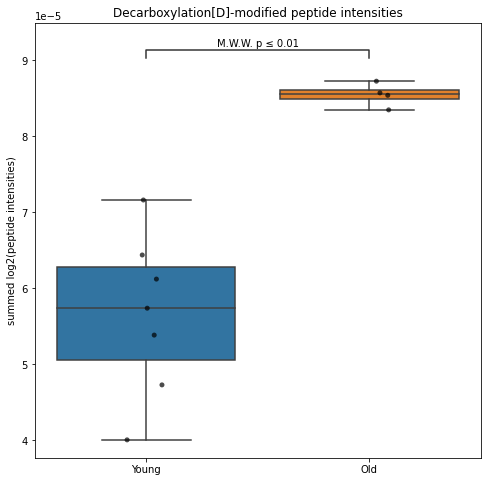

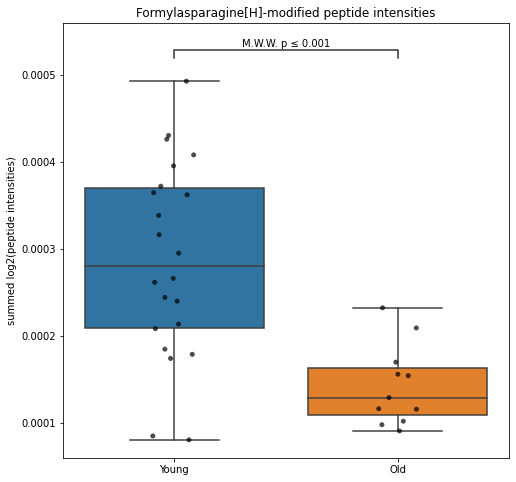

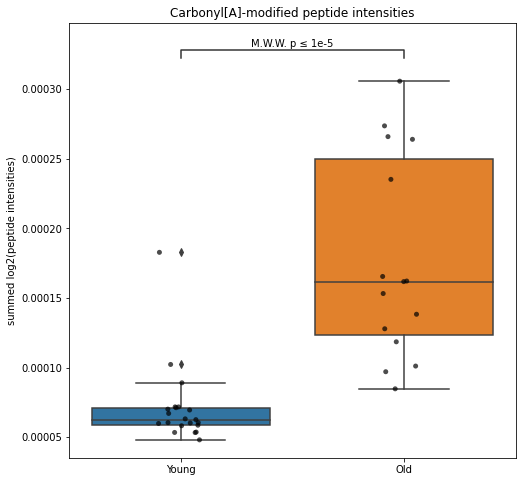

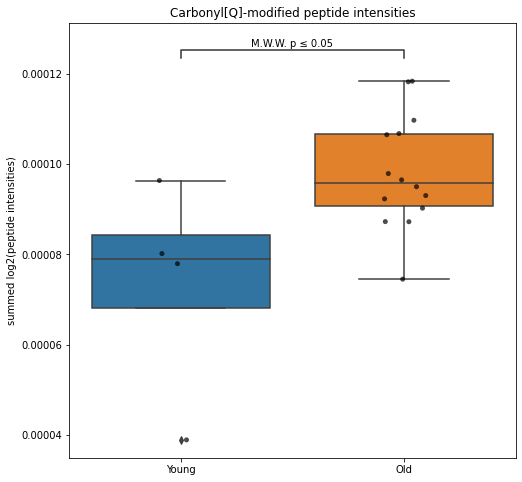

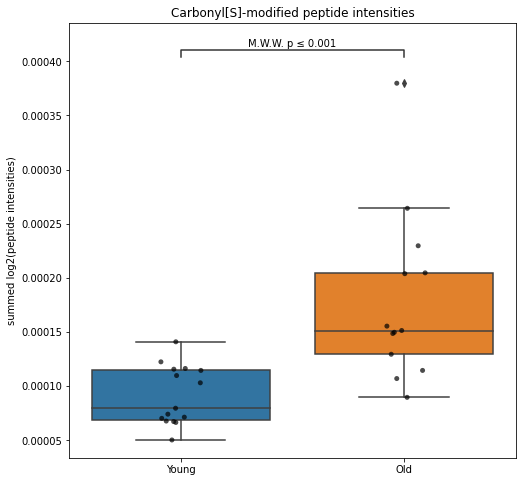

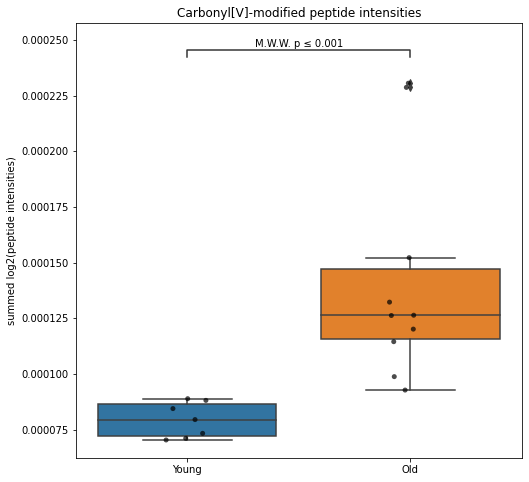

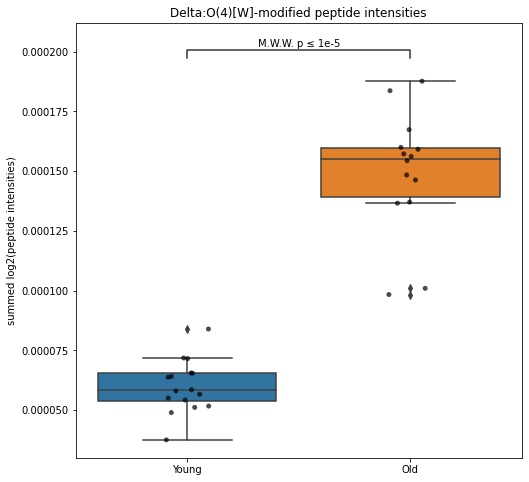

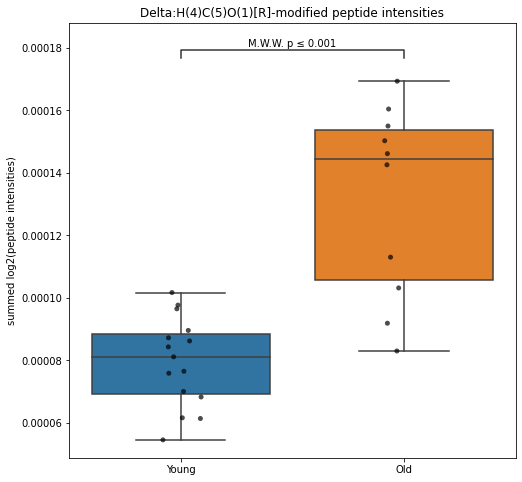

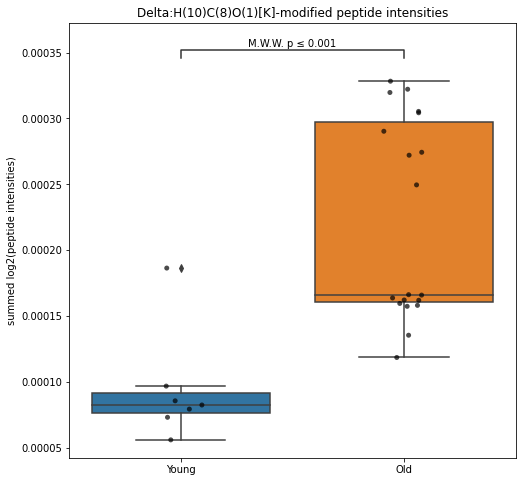

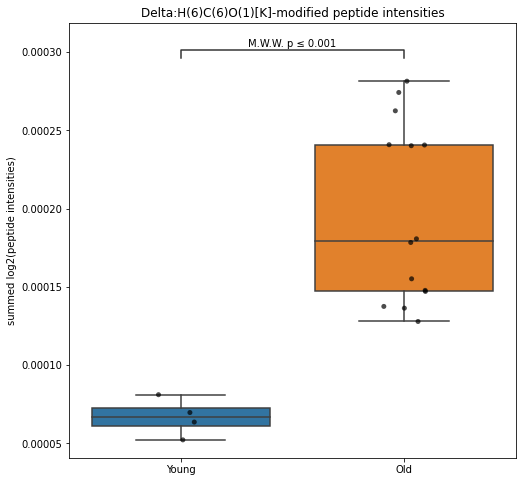

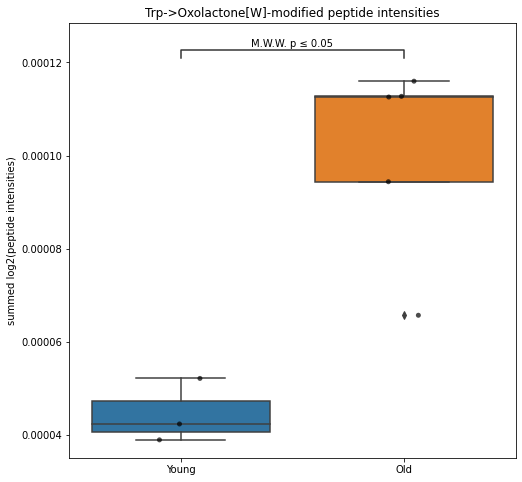

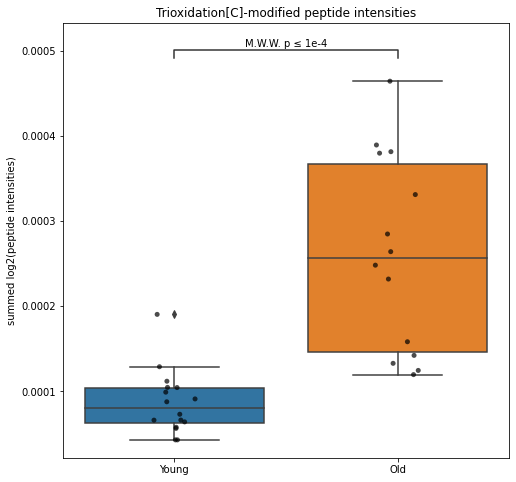

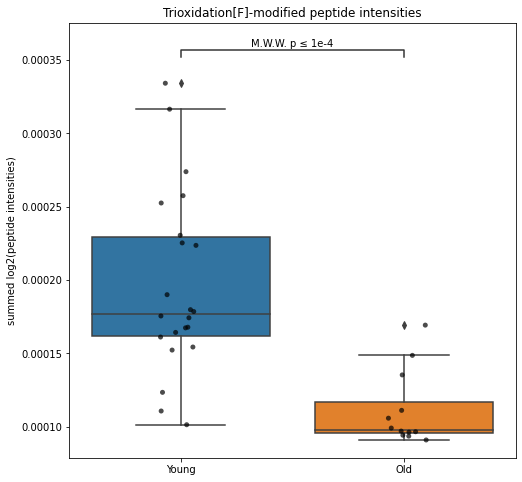

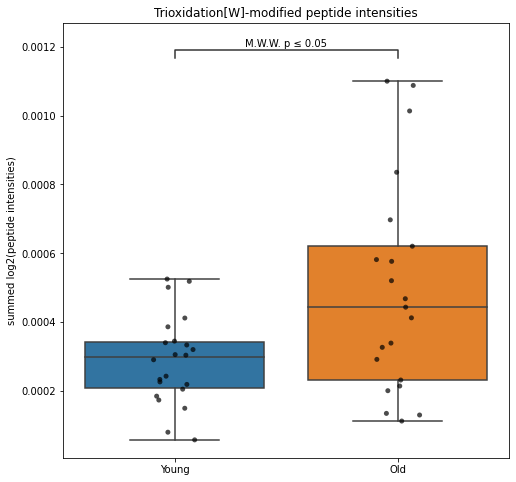

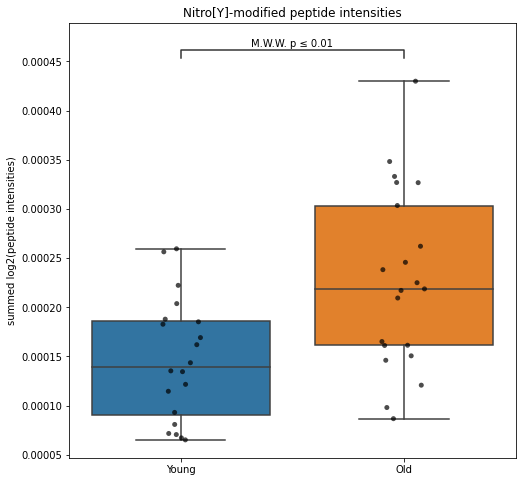

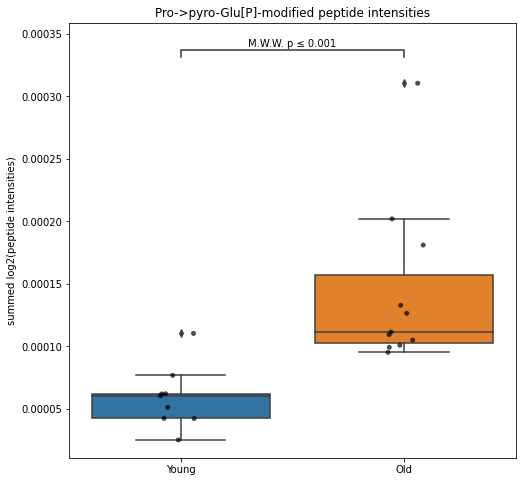

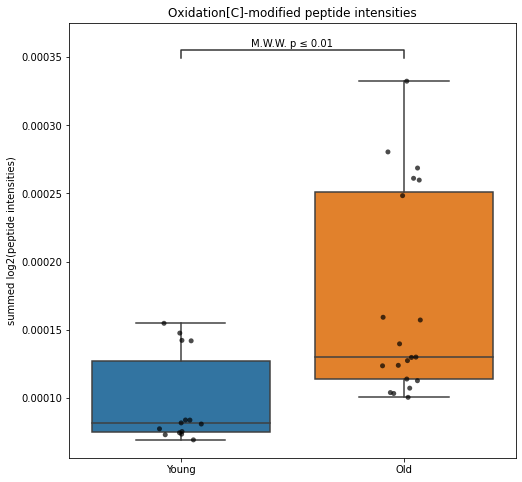

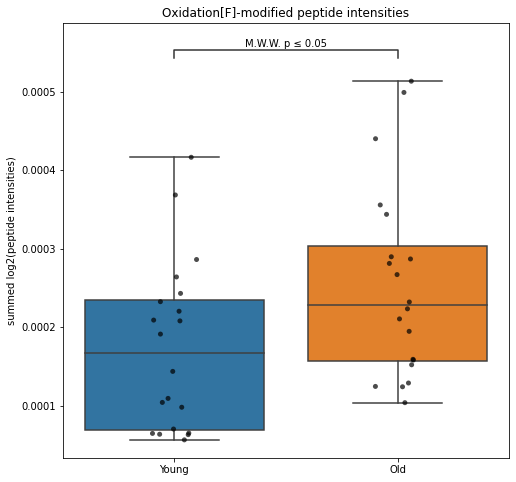

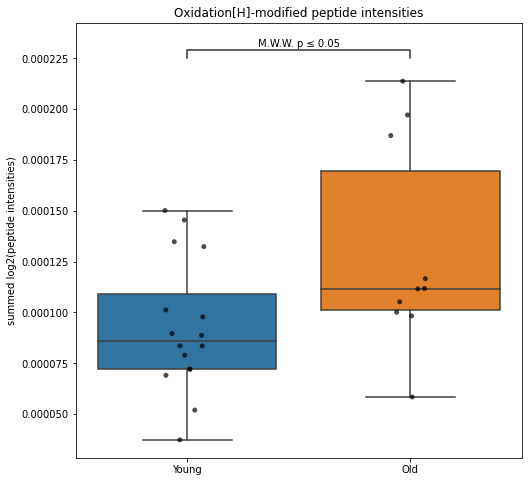

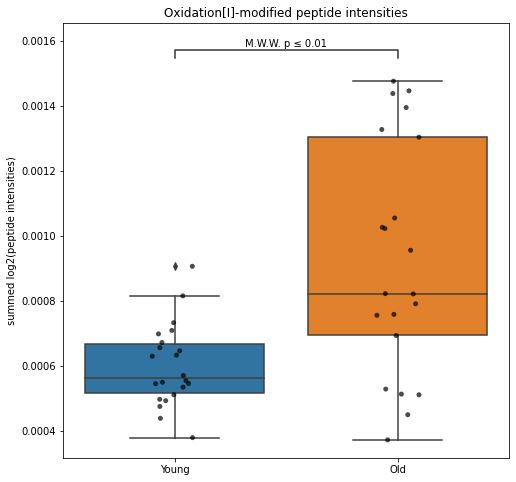

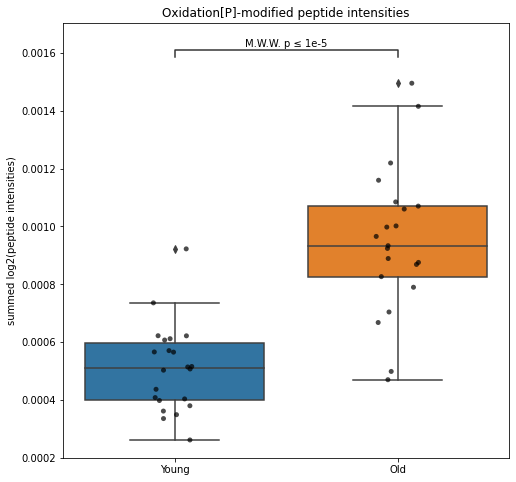

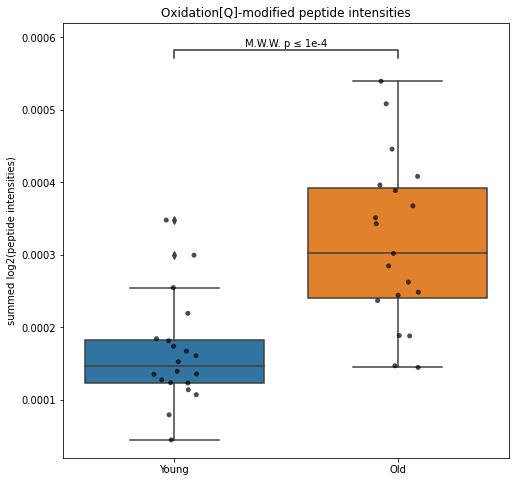

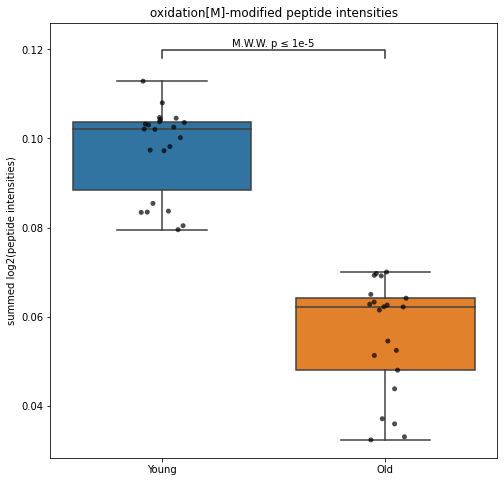

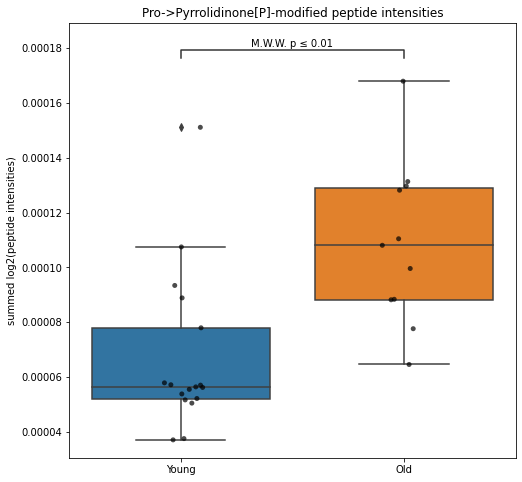

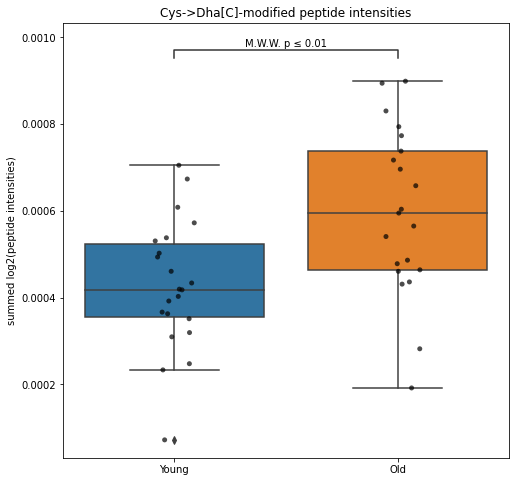

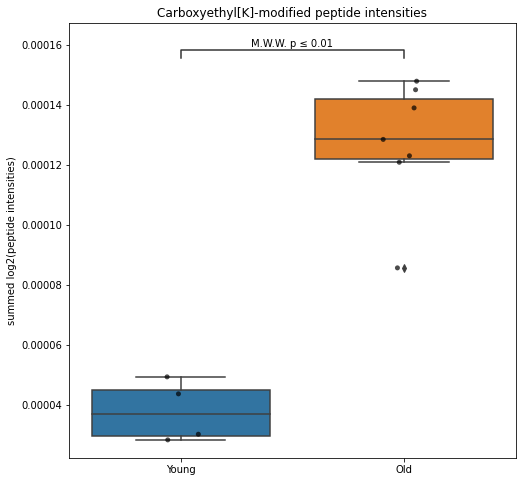

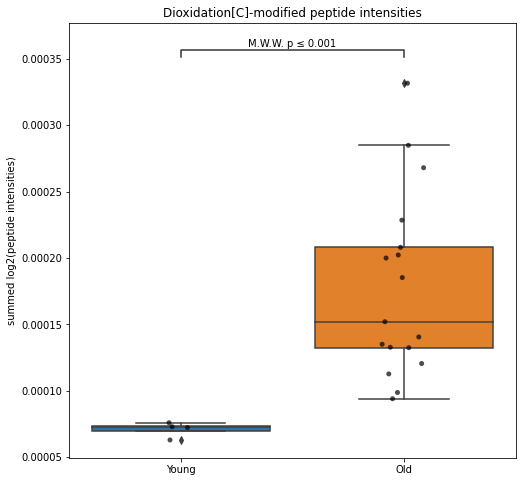

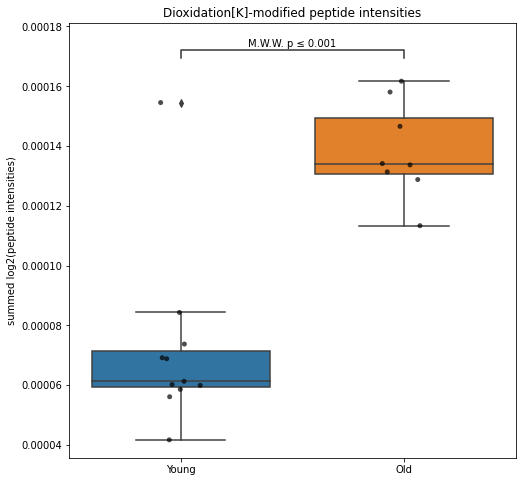

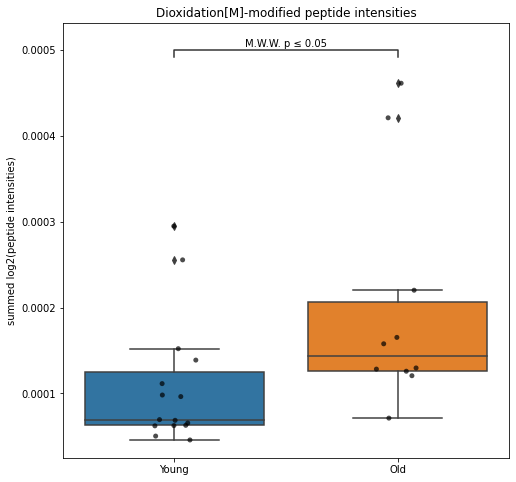

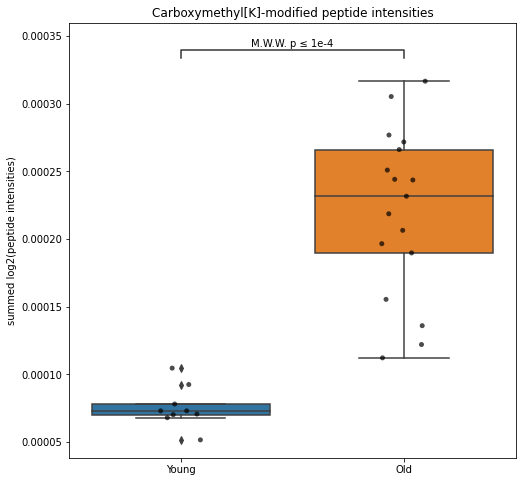

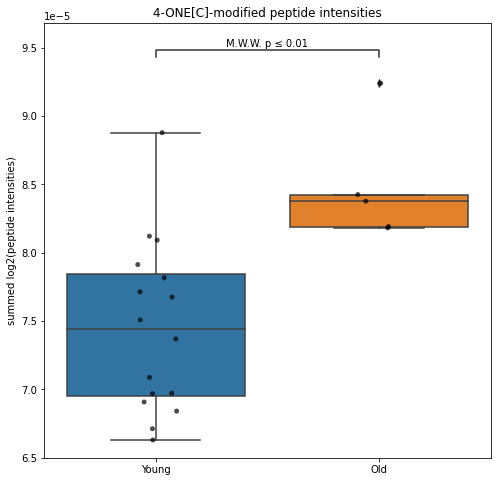

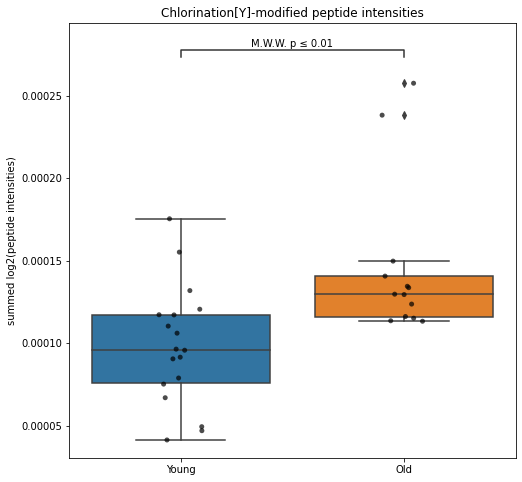

0: 0.006060606060606061 => 0.014452214452214451
1: 0.0006309321615220896 => 0.0027015250544662308
2: 4.464471531452199e-06 => 6.919930873750908e-05
3: 0.046405228758169936 => 0.08991013071895425
4: 0.00032677108737168845 => 0.001790130444757406
5: 0.00010283833813245579 => 0.0007084418849124731
6: 3.567368795444174e-06 => 6.919930873750908e-05
7: 0.00034647686027562696 => 0.001790130444757406
8: 0.00040133779264214044 => 0.0019140725495240543
9: 0.00065359477124183 => 0.0027015250544662308
10: 0.03571428571428571 => 0.0738095238095238
11: 1.3983351274070578e-05 => 0.00017339355579847518
12: 4.3089716520994617e-05 => 0.0003339453030377083
13: 0.033508114420730525 => 0.07163803772707907
14: 0.004656257247125855 => 0.012028664555075126
15: 0.0008292462980650054 => 0.0030243100282370786
16: 0.001365561296999093 => 0.004278830697021059
17: 0.027483421975621553 => 0.06085614866030487
18: 0.037357745273820187 => 0.07471549054764037
19: 0.002115606515852994 => 0.006246076380137411
20: 2.034557

In [9]:
boxplots(Young, Old)

# Log Fold Difference

In [10]:
Old.set_index("Modifications", inplace=True)
Young.set_index("Modifications", inplace=True)

In [11]:
oldmodmed = Old.median(axis=1).to_frame(name="Median").reset_index()

In [12]:
youngmodmed = Young.median(axis=1).to_frame(name="Median").reset_index()

In [13]:
data = pd.merge(left=youngmodmed, right=oldmodmed, on="Modifications", suffixes=["_young", "_old"]).set_index("Modifications")

In [14]:
data

,Median_young,Median_old
Modifications,,
[1384]Homocysteic_acid[M],0.000000,0.000000
[1914]Met->AspSA[M],0.000075,0.000000
[1915]Decarboxylation[D],0.000000,0.000000
[1915]Decarboxylation[E],0.000067,0.000000
[1916]Aspartylurea[H],0.000000,0.000000
...,...,...
[743]4-ONE+Delta:H(-2)O(-1)[H],0.000000,0.000000
[860]G-H1[R],0.000000,0.000000
[936]Chlorination[Y],0.000091,0.000115


In [15]:
import numpy as np
data = data.replace(0, np.nan)
data = data.dropna(how='any', axis=0)
datanozero = data.replace(np.nan, 0)

In [16]:
datanozero["FoldDiff"] = datanozero["Median_old"] / datanozero["Median_young"]

In [17]:
datanozero["LogFoldDiff"] = np.log2(datanozero["FoldDiff"])

In [18]:
datanozero["Old"] = datanozero["LogFoldDiff"]

In [19]:
datanozero["Young"] = 0

In [20]:
datanozero.reset_index(inplace=True)

In [21]:
datanozero["Significant"] = [True,True,False,True,False,True,True,True,False,False,False,True,True,False,False,False,True,False,True,True,False,False,False,False,False,True,True,True,False,False,False,False,False,True]

In [22]:
datanozero

,Modifications,Median_young,Median_old,FoldDiff,LogFoldDiff,Old,Young,Significant
0,[1917]Formylasparagine[H],0.000281,0.000091,0.324215,-1.624976,-1.624976,0,True
1,[1918]Carbonyl[A],0.000062,0.000128,2.078072,1.055246,1.055246,0,True
2,[1918]Carbonyl[I],0.000154,0.000138,0.893053,-0.163182,-0.163182,0,False
3,[1918]Carbonyl[S],0.000069,0.000115,1.659358,0.730625,0.730625,0,True
4,[1922]Pro->HAVA[P],0.000426,0.000294,0.690343,-0.534614,-0.534614,0,False
5,[1925]Delta:O(4)[W],0.000055,0.000137,2.507106,1.326023,1.326023,0,True
6,[345]Trioxidation[C],0.000065,0.000142,2.185038,1.127658,1.127658,0,True
7,[345]Trioxidation[F],0.000177,0.000093,0.528324,-0.920504,-0.920504,0,True
8,[345]Trioxidation[W],0.000297,0.000443,1.491768,0.577023,0.577023,0,False
9,[351]Trp->Kynurenin[W],0.000607,0.000536,0.883482,-0.178727,-0.178727,0,False


In [23]:
Significant = datanozero[datanozero["Significant"] == True]

In [24]:
Significant

,Modifications,Median_young,Median_old,FoldDiff,LogFoldDiff,Old,Young,Significant
0,[1917]Formylasparagine[H],0.000281,0.000091,0.324215,-1.624976,-1.624976,0,True
1,[1918]Carbonyl[A],0.000062,0.000128,2.078072,1.055246,1.055246,0,True
3,[1918]Carbonyl[S],0.000069,0.000115,1.659358,0.730625,0.730625,0,True
5,[1925]Delta:O(4)[W],0.000055,0.000137,2.507106,1.326023,1.326023,0,True
6,[345]Trioxidation[C],0.000065,0.000142,2.185038,1.127658,1.127658,0,True
7,[345]Trioxidation[F],0.000177,0.000093,0.528324,-0.920504,-0.920504,0,True
11,[354]Nitro[Y],0.000135,0.000219,1.621048,0.696927,0.696927,0,True
12,[35]Oxidation[C],0.000074,0.000130,1.751360,0.808476,0.808476,0,True
16,[35]Oxidation[I],0.000563,0.000823,1.461243,0.547196,0.547196,0,True
18,[35]Oxidation[P],0.000511,0.000933,1.828061,0.870314,0.870314,0,True


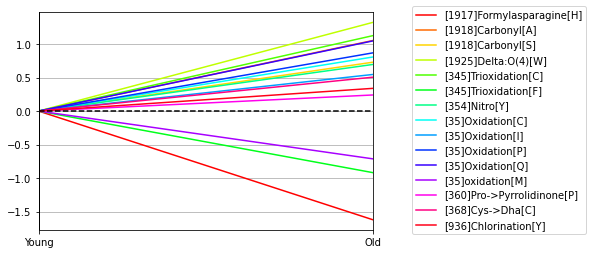

In [25]:
fig, axes = plt.subplots()
pd.plotting.parallel_coordinates(Significant, "Modifications", ["Young","Old"], colormap="hsv")
axes.legend(bbox_to_anchor=(1.1, 1.05))
plt.hlines(y=0,xmin="Young", xmax="Old", colors="Black", linestyles="dashed")
